In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# parameters
start = "2024-01-01"
end   = "2024-07-01"   # exclusive
freq  = "15T"

# generate timestamps
ts = pd.date_range(start=start, end=end, freq=freq, closed="left")

In [ ]:


def simulate_phase(ts, base_current=10, daily_amp=5, noise_std=0.5, phase_shift=0.0):
    seconds_in_day = 24*3600
    t_sec = (ts.view(int) // 10**9) % seconds_in_day
    daily_wave = base_current + daily_amp * np.sin(2*np.pi * (t_sec/seconds_in_day) + phase_shift)
    return daily_wave + np.random.normal(0, noise_std, size=len(ts))

# example for currents
I_a = simulate_phase(ts, phase_shift=0.0)
I_b = simulate_phase(ts, phase_shift=2*np.pi/3)
I_c = simulate_phase(ts, phase_shift=4*np.pi/3)

# voltages similarly, but smaller relative variability
V_a = simulate_phase(ts, base_current=230, daily_amp=2, noise_std=0.2)
V_b = simulate_phase(ts, base_current=230, daily_amp=2, noise_std=0.2, phase_shift=2*np.pi/3)
V_c = simulate_phase(ts, base_current=230, daily_amp=2, noise_std=0.2, phase_shift=4*np.pi/3)

In [ ]:
# Compute total active power assuming unity power factor (ϕ=0) for simplicity:
'LastAverageValueOfImportActivePower' = (I_a*V_a + I_b*V_b + I_c*V_c) / 1000  # in kW

In [ ]:
# Load factor# \text{load_factor} = \frac{\sum P_{\rm total}\;\Delta t}{P_{\max}\times \text{total time}}
# where Pmax=maxP total over a sliding window.
# Consumption ratio Compare observed usage to a customer‑specific baseline (e.g. last year’s same period).

In [ ]:
# Abrupt drop flag
rolling_mean = 'LastAverageValueOfImportActivePower'.rolling(window=96).mean()  # 1 day smoothing
abrupt_drop_flag = (('LastAverageValueOfImportActivePower' < 0.5*rolling_mean) & (rolling_mean>0)).astype(int)

In [ ]:
# Voltage imbalance
voltages = np.vstack([V_a, V_b, V_c]).T
vb = voltages.max(axis=1) - voltages.min(axis=1)
voltage_imbalance = vb / voltages.mean(axis=1)

In [ ]:
# Suspicious pattern Count repeated identical readings over small windows (e.g. meter stuck).

def generate_power_dataset(n_customers, start, end, freq="15T"):
    ts = pd.date_range(start=start, end=end, freq=freq, closed="left")
    rows = []

    for cust in range(1, n_customers+1):
        # simulate three phases
        Ia = simulate_phase(ts, base_current=10, daily_amp=5, noise_std=0.5, phase_shift=0)
        Ib = simulate_phase(ts, base_current=10, daily_amp=5, noise_std=0.5, phase_shift=2*np.pi/3)
        Ic = simulate_phase(ts, base_current=10, daily_amp=5, noise_std=0.5, phase_shift=4*np.pi/3)
        Va = simulate_phase(ts, base_current=230, daily_amp=2, noise_std=0.2, phase_shift=0)
        Vb = simulate_phase(ts, base_current=230, daily_amp=2, noise_std=0.2, phase_shift=2*np.pi/3)
        Vc = simulate_phase(ts, base_current=230, daily_amp=2, noise_std=0.2, phase_shift=4*np.pi/3)

        P = (Ia*Va + Ib*Vb + Ic*Vc) / 1000

        # NTL features
        rolling_mean = P.rolling(window=96, min_periods=1).mean()
        abrupt = ((P < 0.5*rolling_mean) & (rolling_mean>0)).astype(int)

        volt_array = np.vstack([Va, Vb, Vc]).T
        imbalance = (volt_array.max(axis=1) - volt_array.min(axis=1)) / volt_array.mean(axis=1)

        lf = P.sum() / (P.max() * len(P))
        ratio = P / (P.mean() + 1e-6)

        df = pd.DataFrame({
            "customer_id": cust,
            "ts": ts,
            "I_a": Ia, "I_b": Ib, "I_c": Ic,
            "V_a": Va, "V_b": Vb, "V_c": Vc,
            "'LastAverageValueOfImportActivePower'": P,
            "load_factor": lf,
            "consumption_ratio": ratio,
            "abrupt_drop_flag": abrupt,
            "voltage_imbalance": imbalance,
            "suspicious_pattern": (P.diff().abs() < 1e-3).astype(int)
        })
        rows.append(df)

    return pd.concat(rows).reset_index(drop=True)

# Example: generate for 5 customers
df_sample = generate_power_dataset(5, "2024-01-01", "2024-07-01")
print(df_sample.head())


In [ ]:
import pandas as pd
import numpy as np
import etropy as et
from sklearn.cluster import KMeans
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.ensemble import RandomForestClassifier, IsolationForest
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1. Load or generate dataset
def generate_power_dataset(n_customers, start, end, freq="15T"):
    ts = pd.date_range(start=start, end=end, freq=freq, closed="left")
    rows = []
    for cust in range(1, n_customers+1):
        # simulate as before...
        Ia = et.simulate.phase(ts, base=10, amp=5, noise=0.5, shift=0)
        Ib = et.simulate.phase(ts, base=10, amp=5, noise=0.5, shift=2*np.pi/3)
        Ic = et.simulate.phase(ts, base=10, amp=5, noise=0.5, shift=4*np.pi/3)
        Va = et.simulate.phase(ts, base=230, amp=2, noise=0.2, shift=0)
        Vb = et.simulate.phase(ts, base=230, amp=2, noise=0.2, shift=2*np.pi/3)
        Vc = et.simulate.phase(ts, base=230, amp=2, noise=0.2, shift=4*np.pi/3)
        P = (Ia*Va + Ib*Vb + Ic*Vc) / 1000
        df = pd.DataFrame({
            "customer_id": cust,
            "ts": ts,
            "'LastAverageValueOfImportActivePower'": P,
        })
        rows.append(df)
    return pd.concat(rows)

# generate sample
df = generate_power_dataset(50, "2024-01-01", "2024-07-01")

# 2. Exploratory Analysis with Etropy
# Daily cycle
daily = et.stats.daily_cycle(df, id_col='customer_id', ts_col='ts', value_col=''LastAverageValueOfImportActivePower'')
et.plot.daily_cycle(daily, id_list=[1])  # customer 1

# Weekly cycle
weekly = et.stats.weekly_cycle(df, id_col='customer_id', ts_col='ts', value_col=''LastAverageValueOfImportActivePower'')
et.plot.weekly_cycle(weekly, id_list=[1])

# Clustering
profiles = et.features.load_shape(df, id_col='customer_id', ts_col='ts', value_col=''LastAverageValueOfImportActivePower'')
kmeans = KMeans(n_clusters=4).fit(profiles)
labels = kmeans.labels_

# 3. Forecasting for a single customer
cust_df = df[df.customer_id == 1].set_index('ts')
# SARIMAX
sarima_model = SARIMAX(cust_df.'LastAverageValueOfImportActivePower', order=(1,1,1), seasonal_order=(1,1,1,96)).fit()
sarima_fore = sarima_model.get_forecast(steps=96)

# Prophet
prophet_df = cust_df.reset_index().rename(columns={'ts':'ds',''LastAverageValueOfImportActivePower'':'y'})
prop_model = Prophet()
prop_model.fit(prophet_df)
future = prop_model.make_future_dataframe(periods=96, freq='15T')
prop_fore = prop_model.predict(future)

# LSTM with covariates (using previous 'LastAverageValueOfImportActivePower' as feature)
def create_sequences(data, seq_len=96):
    X, y = [], []
    for i in range(len(data)-seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)
series = cust_df.'LastAverageValueOfImportActivePower'.values
X, y = create_sequences(series)
X = X.reshape((X.shape[0], X.shape[1], 1))
model = Sequential([LSTM(50, input_shape=(96,1)), Dense(1)])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=5, batch_size=32)

# 4. NTL Detection
# Supervised
# assume labels_df with columns ['customer_id','ts','ntf_label'] exists
data_sup = df.merge(labels_df, on=['customer_id','ts'])
features = data_sup[[''LastAverageValueOfImportActivePower'']]
clf = RandomForestClassifier()
clf.fit(features, data_sup.ntf_label)

# Unsupervised
iso = IsolationForest(contamination=0.01)
isodata = df[[''LastAverageValueOfImportActivePower'']]
anomaly_scores = iso.fit_predict(isodata)


In [ ]:
import pandas as pd
import numpy as np
import etropy as et
from sklearn.cluster import KMeans
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.ensemble import RandomForestClassifier, IsolationForest
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1. Load or generate dataset
def generate_power_dataset(n_customers, start, end, freq="15T"):
    ts = pd.date_range(start=start, end=end, freq=freq, closed="left")
    rows = []
    for cust in range(1, n_customers+1):
        Ia = et.simulate.phase(ts, base=10, amp=5, noise=0.5, shift=0)
        Ib = et.simulate.phase(ts, base=10, amp=5, noise=0.5, shift=2*np.pi/3)
        Ic = et.simulate.phase(ts, base=10, amp=5, noise=0.5, shift=4*np.pi/3)
        Va = et.simulate.phase(ts, base=230, amp=2, noise=0.2, shift=0)
        Vb = et.simulate.phase(ts, base=230, amp=2, noise=0.2, shift=2*np.pi/3)
        Vc = et.simulate.phase(ts, base=230, amp=2, noise=0.2, shift=4*np.pi/3)
        P = (Ia*Va + Ib*Vb + Ic*Vc) / 1000
        df = pd.DataFrame({
            "customer_id": cust,
            "ts": ts,
            "'LastAverageValueOfImportActivePower'": P,
        })
        rows.append(df)
    return pd.concat(rows).reset_index(drop=True)

# generate sample data
df = generate_power_dataset(50, "2024-01-01", "2024-07-01")

# 2. Exploratory Analysis with Etropy
# Daily cycle
daily = et.stats.daily_cycle(df, id_col='customer_id', ts_col='ts', value_col=''LastAverageValueOfImportActivePower'')
et.plot.daily_cycle(daily, id_list=[1])
# Weekly cycle
weekly = et.stats.weekly_cycle(df, id_col='customer_id', ts_col='ts', value_col=''LastAverageValueOfImportActivePower'')
et.plot.weekly_cycle(weekly, id_list=[1])
# Clustering
profiles = et.features.load_shape(df, id_col='customer_id', ts_col='ts', value_col=''LastAverageValueOfImportActivePower'')
kmeans = KMeans(n_clusters=4).fit(profiles)
labels = kmeans.labels_

# 3. Forecasting for a single customer (ID=1)
cust_df = df[df.customer_id == 1].set_index('ts')
# SARIMAX
sarima_model = SARIMAX(cust_df.'LastAverageValueOfImportActivePower', order=(1,1,1), seasonal_order=(1,1,1,96)).fit(disp=False)
sarima_fore = sarima_model.get_forecast(steps=96)
# Prophet
prophet_df = cust_df.reset_index().rename(columns={'ts':'ds',''LastAverageValueOfImportActivePower'':'y'})
prop_model = Prophet()
prop_model.fit(prophet_df)
future = prop_model.make_future_dataframe(periods=96, freq='15T')
prop_fore = prop_model.predict(future)
# LSTM
def create_sequences(data, seq_len=96):
    X, y = [], []
    for i in range(len(data)-seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)
series = cust_df.'LastAverageValueOfImportActivePower'.values
X, y = create_sequences(series)
X = X.reshape((X.shape[0], X.shape[1], 1))
model = Sequential([LSTM(50, input_shape=(96,1)), Dense(1)])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=5, batch_size=32)

# 4. NTL Detection
# Supervised: create or load 'labels_df' with columns ['customer_id','ts','ntf_label']
# Example: synthetic labeling (1% anomalies per customer)
labels_list = []
for cust in df['customer_id'].unique():
    cust_ts = df[df.customer_id==cust]['ts']
    n = len(cust_ts)
    anomaly_idx = np.random.choice(n, size=int(0.01*n), replace=False)
    for idx in anomaly_idx:
        labels_list.append({'customer_id':cust, 'ts':cust_ts.iloc[idx], 'ntf_label':1})
# fill the rest with normal labels
all_pairs = set((d['customer_id'], d['ts']) for d in labels_list)
for idx, row in df.iterrows():
    pair = (row.customer_id, row.ts)
    if pair not in all_pairs:
        labels_list.append({'customer_id':row.customer_id, 'ts':row.ts, 'ntf_label':0})
labels_df = pd.DataFrame(labels_list)

# merge features with labels for training
data_sup = df.merge(labels_df, on=['customer_id','ts'])
features = data_sup[[''LastAverageValueOfImportActivePower'']]
clf = RandomForestClassifier()
clf.fit(features, data_sup.ntf_label)

# Unsupervised: Isolation Forest on 'LastAverageValueOfImportActivePower'
ios = IsolationForest(contamination=0.01)
anomaly_scores = ios.fit_predict(df[[''LastAverageValueOfImportActivePower'']])
df['anomaly'] = anomaly_scores


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from statsmodels.tsa.statespace.sarimax import SARIMAX
# from prophet import Prophet  # uncomment if fbprophet is installed

# 1. Generate synthetic dataset
def simulate_phase(ts, base, amp, noise, shift=0):
    seconds_in_day = 24 * 3600
    t = (ts.view(int) // 10**9) % seconds_in_day
    wave = base + amp * np.sin(2 * np.pi * (t/seconds_in_day) + shift)
    return wave + np.random.normal(0, noise, len(ts))

def generate_data(n_customers=5, start="2024-01-01", end="2024-07-01"):
    ts = pd.date_range(start, end, freq="15T", closed="left")
    dfs = []
    for cid in range(1, n_customers+1):
        Ia = simulate_phase(ts, 10, 5, 0.5, 0)
        Ib = simulate_phase(ts, 10, 5, 0.5, 2*np.pi/3)
        Ic = simulate_phase(ts, 10, 5, 0.5, 4*np.pi/3)
        Va = simulate_phase(ts, 230, 2, 0.2, 0)
        Vb = simulate_phase(ts, 230, 2, 0.2, 2*np.pi/3)
        Vc = simulate_phase(ts, 230, 2, 0.2, 4*np.pi/3)
        P = (Ia*Va + Ib*Vb + Ic*Vc) / 1000
        df = pd.DataFrame({
            'customer_id': cid,
            'ts': ts,
            ''LastAverageValueOfImportActivePower'': P
        })
        dfs.append(df)
    return pd.concat(dfs)

df = generate_data()

# 2. Exploratory analysis
# Daily cycle
df['time_of_day'] = df['ts'].dt.time
daily = df.groupby('time_of_day')[''LastAverageValueOfImportActivePower''].mean()

plt.figure()
plt.plot(daily.index, daily.values)
plt.title('Average Daily Consumption Cycle')
plt.xlabel('Time of Day')
plt.ylabel(''LastAverageValueOfImportActivePower' (kW)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Weekly cycle
df['weekday'] = df['ts'].dt.day_name()
weekly = df.groupby('weekday')[''LastAverageValueOfImportActivePower''].mean().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)

plt.figure()
plt.plot(weekly.index, weekly.values)
plt.title('Average Weekly Consumption Cycle')
plt.xlabel('Day of Week')
plt.ylabel(''LastAverageValueOfImportActivePower' (kW)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Entropy calculation (Shannon entropy)
from scipy.stats import entropy
entropies = df.groupby('customer_id')[''LastAverageValueOfImportActivePower''].apply(
    lambda x: entropy(np.histogram(x, bins=30)[0] + 1)
)

plt.figure()
entropies.plot(kind='bar')
plt.title('Shannon Entropy of Consumption per Customer')
plt.xlabel('Customer ID')
plt.ylabel('Entropy')
plt.tight_layout()
plt.show()

# Clustering by daily load shape
# Create feature vectors: average daily cycle per customer
features = df.groupby(['customer_id', 'time_of_day'])[''LastAverageValueOfImportActivePower''].mean().unstack()
kmeans = KMeans(n_clusters=3, random_state=0).fit(features)
cluster_centers = kmeans.cluster_centers_

plt.figure()
for center in cluster_centers:
    plt.plot(features.columns, center, alpha=0.7)
plt.title('Cluster Centers of Daily Load Shapes')
plt.xlabel('Time of Day')
plt.ylabel(''LastAverageValueOfImportActivePower' (kW)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Forecasting (example SARIMAX for customer 1)
cust1 = df[df['customer_id']==1].set_index('ts')[''LastAverageValueOfImportActivePower'']
model = SARIMAX(cust1, order=(1,1,1), seasonal_order=(1,1,1,96))
sarimax_res = model.fit(disp=False)
print(sarimax_res.summary())

# 4. NTL detection
# Simulate labels for supervised learning (random for example)
features_ntl = df.copy()
# simple NTL features
features_ntl['rolling_mean'] = features_ntl.groupby('customer_id')[''LastAverageValueOfImportActivePower''].transform(lambda x: x.rolling(96).mean())
features_ntl['drop_flag'] = (features_ntl[''LastAverageValueOfImportActivePower''] < 0.5 * features_ntl['rolling_mean']).astype(int)

# label (1 for illegal) ~ small fraction
np.random.seed(0)
features_ntl['illegal'] = (np.random.rand(len(features_ntl)) < 0.01).astype(int)

clf = LogisticRegression(max_iter=1000)
X = features_ntl[['drop_flag']].fillna(0)
y = features_ntl['illegal']
clf.fit(X, y)
y_pred = clf.predict(X)
print(classification_report(y, y_pred))

# Unsupervised: Isolation Forest
iso = IsolationForest(contamination=0.01, random_state=0)
features_ntl['anomaly_score'] = iso.fit_predict(X)
print(features_ntl['anomaly_score'].value_counts())


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1. Generate synthetic dataset
def simulate_phase(ts, base, amp, noise, shift=0):
    seconds_in_day = 24 * 3600
    t = (ts.view(int) // 10**9) % seconds_in_day
    wave = base + amp * np.sin(2 * np.pi * (t/seconds_in_day) + shift)
    return wave + np.random.normal(0, noise, len(ts))

def generate_data(n_customers=5, start="2024-01-01", end="2024-07-01"):
    ts = pd.date_range(start, end, freq="15T", inclusive="left")
    dfs = []
    for cid in range(1, n_customers+1):
        Ia = simulate_phase(ts, 10, 5, 0.5, 0)
        Ib = simulate_phase(ts, 10, 5, 0.5, 2*np.pi/3)
        Ic = simulate_phase(ts, 10, 5, 0.5, 4*np.pi/3)
        Va = simulate_phase(ts, 230, 2, 0.2, 0)
        Vb = simulate_phase(ts, 230, 2, 0.2, 2*np.pi/3)
        Vc = simulate_phase(ts, 230, 2, 0.2, 4*np.pi/3)
        P = (Ia*Va + Ib*Vb + Ic*Vc) / 1000
        df = pd.DataFrame({
            'customer_id': cid,
            'ts': ts,
            ''LastAverageValueOfImportActivePower'': P
        })
        dfs.append(df)
    return pd.concat(dfs)

df = generate_data()

# 2. Exploratory analysis
# Daily cycle
df['time_of_day'] = df['ts'].dt.strftime('%H:%M')
daily = df.groupby('time_of_day')[''LastAverageValueOfImportActivePower''].mean()
x = list(range(len(daily)))

plt.figure()
plt.plot(x, daily.values)
plt.title('Average Daily Consumption Cycle')
plt.xlabel('Time of Day')
plt.ylabel(''LastAverageValueOfImportActivePower' (kW)')
plt.xticks(x[::16], daily.index[::16], rotation=45)
plt.tight_layout()
plt.show()

# Weekly cycle
df['weekday'] = df['ts'].dt.day_name()
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
weekly = df.groupby('weekday')[''LastAverageValueOfImportActivePower''].mean().reindex(order)

plt.figure()
plt.plot(order, weekly.values)
plt.title('Average Weekly Consumption Cycle')
plt.xlabel('Day of Week')
plt.ylabel(''LastAverageValueOfImportActivePower' (kW)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Entropy calculation (Shannon entropy)
from scipy.stats import entropy
entropies = df.groupby('customer_id')[''LastAverageValueOfImportActivePower''].apply(
    lambda x: entropy(np.histogram(x, bins=30)[0] + 1)
)

plt.figure()
entropies.plot(kind='bar')
plt.title('Shannon Entropy of Consumption per Customer')
plt.xlabel('Customer ID')
plt.ylabel('Entropy')
plt.tight_layout()
plt.show()

# Clustering by daily load shape
features = df.groupby(['customer_id', 'time_of_day'])[''LastAverageValueOfImportActivePower''].mean().unstack()
kmeans = KMeans(n_clusters=3, random_state=0).fit(features)
cluster_centers = kmeans.cluster_centers_

plt.figure()
for center in cluster_centers:
    plt.plot(x, center, alpha=0.7)
plt.title('Cluster Centers of Daily Load Shapes')
plt.xlabel('Time of Day')
plt.ylabel(''LastAverageValueOfImportActivePower' (kW)')
plt.xticks(x[::16], daily.index[::16], rotation=45)
plt.tight_layout()
plt.show()

# 3. Forecasting (example SARIMAX for customer 1)
cust1 = df[df['customer_id']==1].set_index('ts')[''LastAverageValueOfImportActivePower'']
model = SARIMAX(cust1, order=(1,1,1), seasonal_order=(1,1,1,96))
sarimax_res = model.fit(disp=False)
print(sarimax_res.summary())

# 4. NTL detection
features_ntl = df.copy()
features_ntl['rolling_mean'] = features_ntl.groupby('customer_id')[''LastAverageValueOfImportActivePower''].transform(lambda x: x.rolling(96).mean())
features_ntl['drop_flag'] = (features_ntl[''LastAverageValueOfImportActivePower''] < 0.5 * features_ntl['rolling_mean']).astype(int)

# Simulate labels
np.random.seed(0)
features_ntl['illegal'] = (np.random.rand(len(features_ntl)) < 0.01).astype(int)

clf = LogisticRegression(max_iter=1000)
X = features_ntl[['drop_flag']].fillna(0)
y = features_ntl['illegal']
clf.fit(X, y)
y_pred = clf.predict(X)
print(classification_report(y, y_pred))

iso = IsolationForest(contamination=0.01, random_state=0)
features_ntl['anomaly_score'] = iso.fit_predict(X)
print(features_ntl['anomaly_score'].value_counts())


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import entropy
from sklearn.cluster import KMeans
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


/home/ali/anaconda3/envs/tf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
2025-07-13 11:58:22.402116: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-13 11:58:22.491864: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-13 11:58:22.526582: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN wh

In [2]:
# ----------------------------------------------------------------------
# 1. Load data
# ----------------------------------------------------------------------
def load_data(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df


In [32]:
# ----------------------------------------------------------------------
# 2. Exploratory Analysis
# ----------------------------------------------------------------------

def plot_daily_weekly_cycles(df: pd.DataFrame, customer_id: int):
    cust = df[df['MeterID'] == customer_id].set_index('timestamp')
    # daily cycle
    daily = cust['LastAverageValueOfImportActivePower'].groupby(cust.index.time).mean()
    plt.figure()
    plt.plot(daily.index.astype(str), daily.values)
    plt.xticks(rotation=90)
    plt.title(f"Daily cycle for customer {customer_id}")
    plt.xlabel('Time of day')
    plt.ylabel('Average Power')
    plt.show()
    # weekly cycle
    weekly = cust['LastAverageValueOfImportActivePower'].groupby(cust.index.dayofweek).mean()
    plt.figure()
    plt.bar(weekly.index, weekly.values)
    plt.title(f"Weekly cycle for customer {customer_id}")
    plt.xlabel('Day of week')
    plt.ylabel('Average Power')
    plt.show()


def compute_entropy(ts: pd.Series, bins: int = 50) -> float:
    counts, _ = np.histogram(ts, bins=bins, density=False)
    probs = counts / counts.sum()
    return entropy(probs, base=2)


def plot_entropy_all(df: pd.DataFrame):
    ent = df.groupby('MeterID')['LastAverageValueOfImportActivePower'].apply(compute_entropy)
    ent.plot(kind='hist', bins=20)
    plt.title('Distribution of Entropy across customers')
    plt.xlabel('Entropy')
    plt.show()


def cluster_load_shapes(df: pd.DataFrame, n_clusters: int = 2):
    # extract daily load shapes
    pivot = df.pivot_table(values='LastAverageValueOfImportActivePower', index='MeterID', columns=df['timestamp'].dt.hour * 4 + df['timestamp'].dt.minute // 15)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(pivot.fillna(0))
    return kmeans.labels_


In [4]:
# ----------------------------------------------------------------------
# 3. Forecasting
# ----------------------------------------------------------------------

def forecast_sarimax(df: pd.DataFrame, customer_id: int):
    cust = df[df['MeterID'] == customer_id].set_index('timestamp')['LastAverageValueOfImportActivePower'].resample('15T').mean()
    model = SARIMAX(cust, order=(1,1,1), seasonal_order=(1,1,1,96))
    res = model.fit(disp=False)
    forecast = res.get_forecast(steps=96)
    return forecast


def forecast_prophet(df: pd.DataFrame, customer_id: int):
    cust = df[df['MeterID'] == customer_id][['timestamp', 'LastAverageValueOfImportActivePower']].rename(columns={'timestamp':'ds','LastAverageValueOfImportActivePower':'y'})
    m = Prophet()
    m.fit(cust)
    future = m.make_future_dataframe(periods=96, freq='15T')
    forecast = m.predict(future)
    return forecast


def forecast_lstm(df: pd.DataFrame, customer_id: int, lookback: int = 96):
    cust = df[df['MeterID']==customer_id].set_index('timestamp')['LastAverageValueOfImportActivePower'].resample('15T').mean().fillna(method='ffill')
    data = cust.values
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    model = Sequential([LSTM(50, input_shape=(lookback,1)), Dense(1)])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=10, verbose=1)
    return model, X_test


In [37]:

# ----------------------------------------------------------------------
# 4. NTL Detection
# ----------------------------------------------------------------------

def ntl_supervised(df: pd.DataFrame, labels: pd.Series):
    features = df.drop(columns=['MeterID','timestamp', 'cluster','NTL_Type'])
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)
    clf = RandomForestClassifier(n_estimators=100, random_state=0)
    clf.fit(X_train, y_train)
    return clf, X_test, y_test


def ntl_unsupervised(df: pd.DataFrame):
    features = df.drop(columns=['MeterID','timestamp', 'cluster','NTL_Type'])
    iso = IsolationForest(contamination=0.01, random_state=0)
    scores = iso.fit_predict(features)
    return scores


In [36]:
df.head(1)

,MeterID,timestamp,Phase,NTL_Type,ReactiveCumulativeEnergyImport(+R),ReactiveCumulativeEnergyImport(-R),DemandRegisterActiveEnergyCombinedTotal,LastAverageValueOfImportActivePower,LastAverageValueOfPFTotal,LastAverageValueOfCurrent,LastAverageValueOfVoltageL,cluster
0,0,2024-01-01,3,normal,0.047394,0,0.166093,0.166093,0.961618,0.444978,224.104787,0


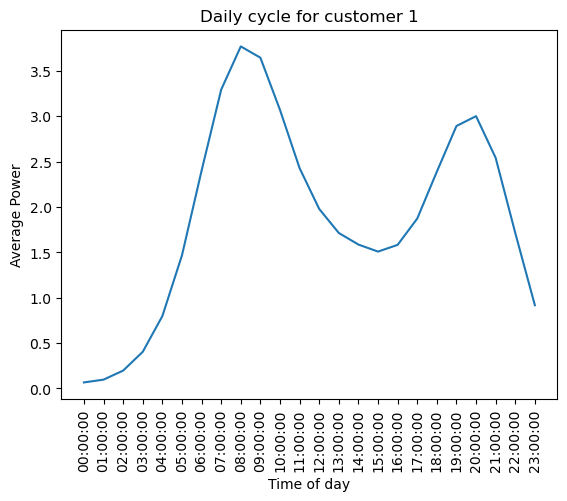

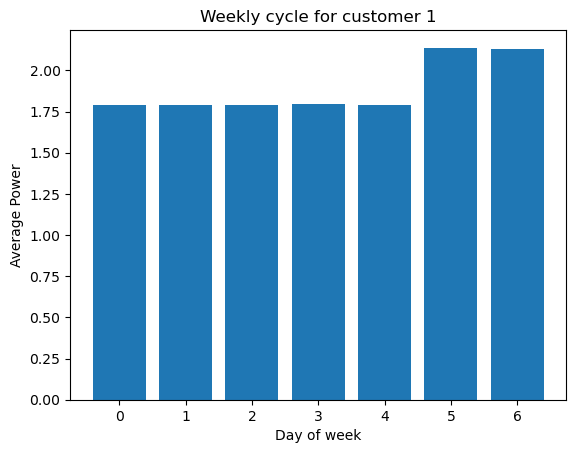

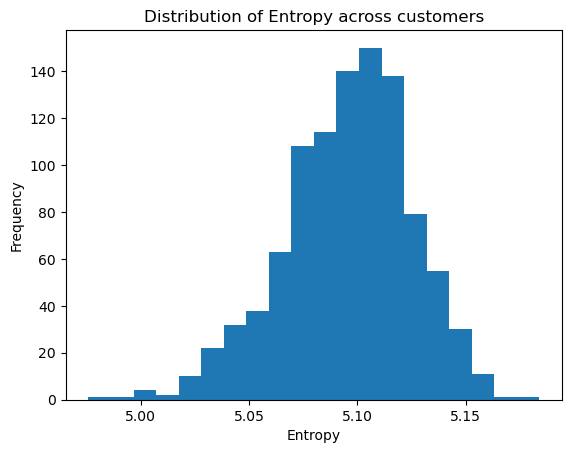

In [6]:
# ----------------------------------------------------------------------
# Example pipeline
# ----------------------------------------------------------------------
df = load_data('../data/smart_meter_data_with_ntl.csv')
plot_daily_weekly_cycles(df, customer_id=1)
plot_entropy_all(df)


In [33]:
labels = cluster_load_shapes(df)
df['cluster'] = df['MeterID'].map(dict(zip(df['MeterID'].unique(), labels)))

In [ ]:
# Forecast
f_sarimax = forecast_sarimax(df, 1)


In [ ]:

f_prophet = forecast_prophet(df, 1)


In [ ]:

lstm_model, X_test = forecast_lstm(df, 1)


In [38]:

# NTL
# supervised
clf, X_t, y_t = ntl_supervised(df, labels=df['NTL_Type'])


In [47]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay

# Predictions
y_pred = clf.predict(X_t)
y_prob = clf.predict_proba(X_t)[:, 1]  # for ROC AUC

# Metrics
print(confusion_matrix(y_t, y_pred))
print(classification_report(y_t, y_pred))


[[  56086      74       0       0]
 [      0 1581525       0       1]
 [      0     240   59423       0]
 [      0     807       0   58644]]
                precision    recall  f1-score   support

current_tamper       1.00      1.00      1.00     56160
        normal       1.00      1.00      1.00   1581526
partial_bypass       1.00      1.00      1.00     59663
voltage_tamper       1.00      0.99      0.99     59451

      accuracy                           1.00   1756800
     macro avg       1.00      1.00      1.00   1756800
  weighted avg       1.00      1.00      1.00   1756800



In [45]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# 1. Binarize string labels to one-hot encoded matrix
classes = ['normal', 'current_tamper', 'voltage_tamper', 'partial_bypass']
y_test_bin = label_binarize(y_t, classes=classes)

# 2. Get predicted class probabilities
y_prob = clf.predict_proba(X_t)

# 3. Compute multiclass ROC AUC using OVR
roc_auc = roc_auc_score(y_test_bin, y_prob, multi_class='ovr')
print(f"Multiclass ROC AUC: {roc_auc:.3f}")


Multiclass ROC AUC: 0.323


In [46]:
from sklearn.metrics import roc_auc_score

for i, cls in enumerate(classes):
    auc = roc_auc_score(y_test_bin[:, i], y_prob[:, i])
    print(f"AUC for {cls}: {auc:.3f}")


AUC for normal: 0.324
AUC for current_tamper: 0.016
AUC for voltage_tamper: 0.479
AUC for partial_bypass: 0.474


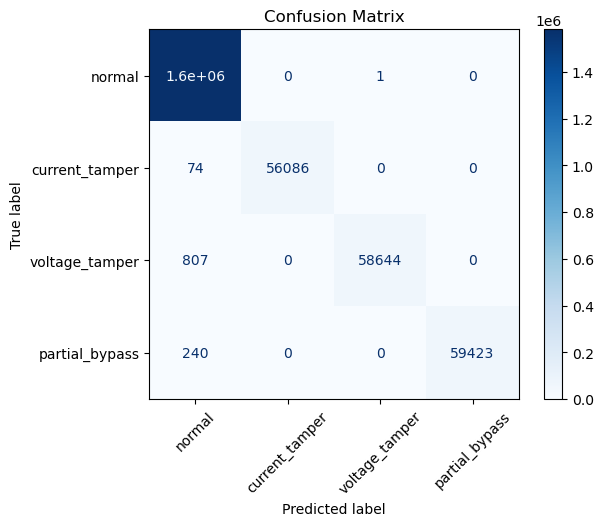

In [48]:
cm = confusion_matrix(y_t, y_pred, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

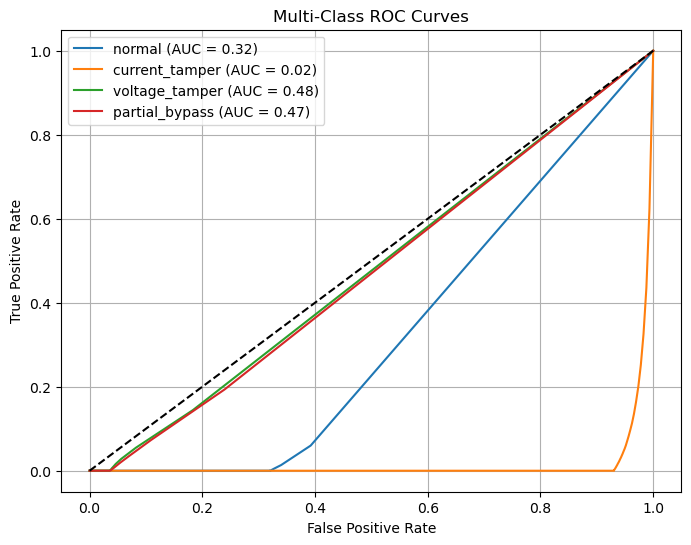

In [49]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# One-hot encode true labels
y_test_bin = label_binarize(y_t, classes=classes)
y_prob = clf.predict_proba(X_t)

# Plot ROC for each class
plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # random baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curves")
plt.legend()
plt.grid(True)
plt.show()


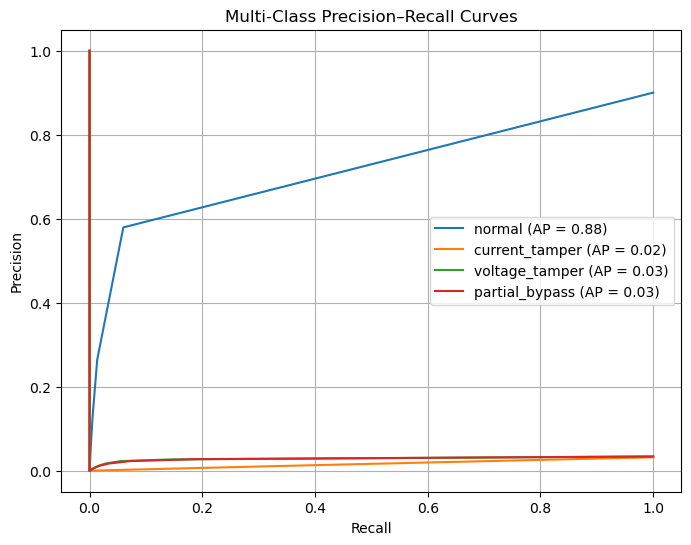

In [50]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f"{cls} (AP = {ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Multi-Class Precision–Recall Curves")
plt.legend()
plt.grid(True)
plt.show()


/home/ali/anaconda3/envs/tf/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


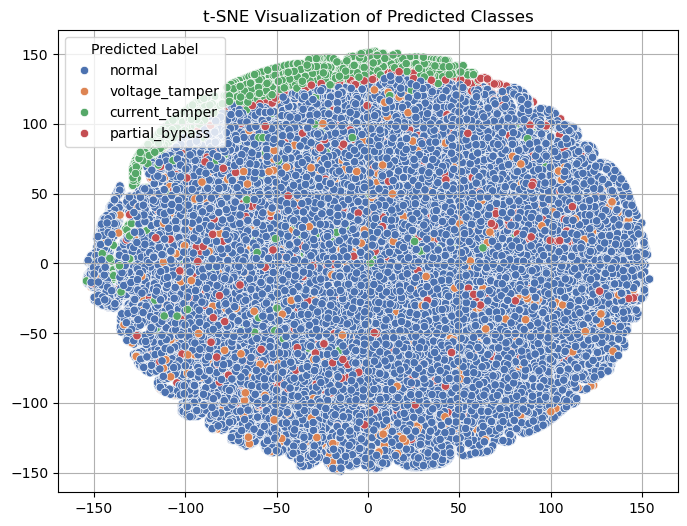

In [52]:
from sklearn.manifold import TSNE
import seaborn as sns

# Reduce feature space to 2D
X_vis = TSNE(n_components=2, random_state=0).fit_transform(X_t)

# Plot with seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_vis[:, 0], y=X_vis[:, 1], hue=y_pred, palette='deep')
plt.title("t-SNE Visualization of Predicted Classes")
plt.legend(title='Predicted Label')
plt.grid(True)
plt.show()


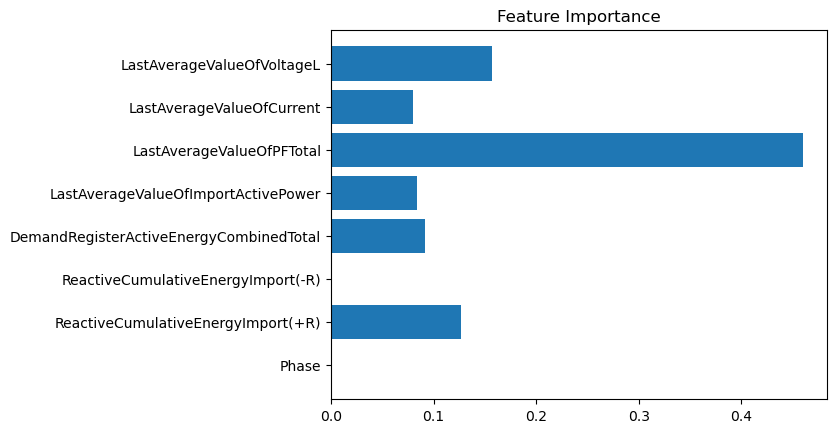

In [42]:
importances = clf.feature_importances_
features = X_t.columns
plt.barh(features, importances)
plt.title("Feature Importance")
plt.show()

In [ ]:
# df_unlabeled is a dataset with same features, but unknown NTL status
df_unlabeled['NTL_Prob'] = clf.predict_proba(df_unlabeled.drop(columns=['customer_id', 'ts']))[:, 1]

# Flag customers with high predicted probability
df_unlabeled['NTL_Flag'] = df_unlabeled['NTL_Prob'] > 0.85  # or any chosen threshold


suspicious_ids = df_unlabeled[df_unlabeled['NTL_Flag']]['customer_id'].unique()
for cid in suspicious_ids:
    plot_daily_weekly_cycles(df_raw, customer_id=cid)

In [ ]:
# Unsupervised
anomalies = ntl_unsupervised(df)
